# Gesture Recognition Case Study
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

# Import Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from imageio import imread
from scipy.ndimage import zoom
from skimage.transform import resize,rescale
import datetime
import os
import cv2
import matplotlib.pyplot as plt

`We set the random seed so that the results don't vary drastically.`

In [4]:
np.random.seed(42)
import random as rn
rn.seed(42)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(42)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
# batch_size = #experiment with the b/atch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
# Paramters
num_frames_video = 30
img_height = 160
img_width = 160
num_channels=3
num_classes=5
num_epochs=10
num_imgs_per_video=16
batch_size=30



In [7]:
# Cropping and Resizing images
def crop_resize_img(img):
    if img.shape[0]!= img.shape[1]:# images of size 160x120
        img = img[0:110,10:150]
    else:
        img = img[10:310,10:310]
    resized_image = resize(img, (img_height,img_width))
    return resized_image

In [8]:
# Plotting
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [9]:
img_idx = np.linspace(0,num_frames_video-1,16).astype('int')
# create a list of image numbers you want to use for a particular video 
num_imgs_per_video = len(img_idx)
def generator(source_path, folder_list, batch_size,crop_resize=False,augmentation=False,ablation=None):
    print('Source path =', source_path,'; batch size =', batch_size)
    if(ablation!=None): # Ablation experiment
        folder_list=folder_list[:ablation]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size# calculate the number of batches
        for batch in range(num_batches): # iterate over the number of batches
            batch_data = np.zeros((batch_size,num_imgs_per_video,img_height,img_width,num_channels)) ## num_imgs_per_video is the number of images you use for each video, (img_height,img_width) is the final size of the input images and 3 is the number of channels RGB
            batch_labels= np.zeros((batch_size,num_classes))  # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])  # read all the images in the folder
                for idx, item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    # crop the images and resize them. Note that the images are of 2 different shape
                    # and the conv3D will throw error if the inputs in a batch have different shapes
                    if (crop_resize):
                        image = crop_resize_img(image) # crop and resize image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                    if (augmentation):
                        batch_data_aug = np.zeros((batch_size,num_imgs_per_video,img_height,img_width,num_channels)) ## num_imgs_per_video is the number of images you use for each video, (img_height,img_width) is the final size of the input images and 3 is the number of channels RGB
                        shifted = cv2.warpAffine(image, 
                                                 np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                                (image.shape[0], image.shape[1]))
                        # image = cv2.Canny(np.uint8(shifted),100,200)
                        batch_data_aug[folder,idx,:,:,0] = (image[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if (augmentation):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])


        yield batch_data, batch_labels, #you yield the batch_data and the batch_labels, remember what does yield do

        # Code for remaining data points which are left after full batches
        if (len(folder_list)!= batch_size*num_batches):
            batch_size= len(folder_list)-(batch_size*num_batches)
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            


In [20]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from keras.layers.convolutional import Conv2D ,MaxPooling2D ,Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here

# <font color='maroon'>Conv 3d Models</font>

In [14]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(num_imgs_per_video,img_height,img_width,num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))


model.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 80, 80, 32)     1

In [12]:
ablation_train= 100
ablation_val = 50
if (ablation_train!=None): # Ablation experiment
    if (ablation_train%batch_size) == 0:
        steps_per_epoch = int(ablation_train/batch_size)
    else:
        steps_per_epoch = (ablation_train//batch_size) + 1
    if (ablation_val%batch_size) == 0:
        validation_steps = int(ablation_val/batch_size)
    else:
        validation_steps = (ablation_val//batch_size) + 1
else:
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
train_generator = generator(train_path, train_doc, batch_size,crop_resize=True,augmentation=False,ablation=ablation_train)
val_generator = generator(val_path, val_doc, batch_size,crop_resize=True,augmentation=False,ablation=ablation_val)

## Model 1: Running on ablation dataset( training sample=100 and validation samples= 50 ) with Image cropping and resizing (160 x 160) , optimizer= adam , and no image augmentation

In [17]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = ../input/gesturerecognition/Project_data/train ; batch size = 30
Epoch 1/10
4/4 [==============================] - 70s 21s/step - loss: 1.4548 - categorical_accuracy: 0.4238 - val_loss: 1.6288 - val_categorical_accuracy: 0.1000
Epoch 2/10
4/4 [==============================] - 74s 24s/step - loss: 1.4685 - categorical_accuracy: 0.4400 - val_loss: 1.5568 - val_categorical_accuracy: 0.3000
Epoch 3/10
4/4 [==============================] - 74s 25s/step - loss: 1.0510 - categorical_accuracy: 0.5500 - val_loss: 1.6409 - val_categorical_accuracy: 0.2000
Epoch 4/10
4/4 [==============================] - 73s 24s/step - loss: 1.1259 - categorical_accuracy: 0.4967 - val_loss: 1.5750 - val_categorical_accuracy: 0.3000
Epoch 5/10
4/4 [==============================] - 73s 24s/step - loss: 0.7725 - categorical_accuracy: 0.7467 - val_loss: 1.8668 - val_categorical_accuracy: 0.1000
Epoch 6/10
4/4 [==============================] - 75s 25s/step - loss: 0.4932 - categorical_accuracy: 0.80

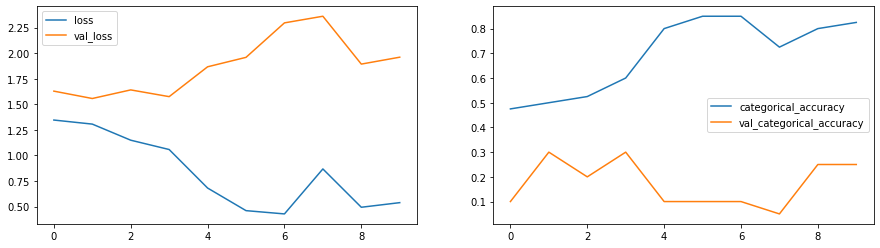

In [19]:
plot(model_history)

`Clearly we can see from above plots and accuracy on training and validation dataset, model is performing well on ablation training set.`

## Model 2: Running on ablation dataset( training sample=100 and validation samples= 50 ) with Image cropping and resizing (160 x 160), optimizer= RMSProp and  image augumentation

In [20]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(num_imgs_per_video,img_height,img_width,num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))


model.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.RMSprop()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 80, 80, 32)    

In [21]:
train_generator = generator(train_path, train_doc, batch_size,crop_resize=True,augmentation=False,ablation=ablation_train)
val_generator = generator(val_path, val_doc, batch_size,crop_resize=True,augmentation=False,ablation=ablation_val)

In [23]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = ../input/gesturerecognition/Project_data/train ; batch size = 30
Epoch 1/10
4/4 [==============================] - 58s 18s/step - loss: 1.6200 - categorical_accuracy: 0.3717 - val_loss: 1.9595 - val_categorical_accuracy: 0.2000
Epoch 2/10
4/4 [==============================] - 68s 22s/step - loss: 1.2567 - categorical_accuracy: 0.5433 - val_loss: 1.6979 - val_categorical_accuracy: 0.0667
Epoch 3/10
4/4 [==============================] - 75s 25s/step - loss: 0.9666 - categorical_accuracy: 0.7200 - val_loss: 1.5936 - val_categorical_accuracy: 0.4000
Epoch 4/10
4/4 [==============================] - 72s 24s/step - loss: 0.9760 - categorical_accuracy: 0.6700 - val_loss: 1.6586 - val_categorical_accuracy: 0.2500
Epoch 5/10
4/4 [==============================] - 73s 24s/step - loss: 0.6997 - categorical_accuracy: 0.7800 - val_loss: 3.0184 - val_categorical_accuracy: 0.1500
Epoch 6/10
4/4 [==============================] - 70s 23s/step - loss: 1.1870 - categorical_accuracy: 0.51

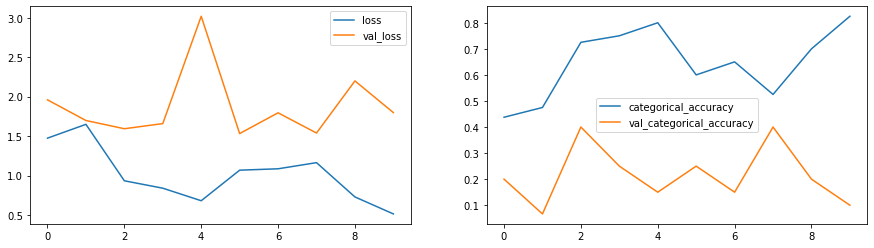

In [24]:
plot(model_history)

## Model 3: Running on ablation dataset( training sample=100 and validation samples= 50 ) with Image cropping and resizing (160 x 160) and  image augumentation

In [29]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(num_imgs_per_video,img_height,img_width,num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.25))


model.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_13 (Activation)   (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 80, 80, 32)    

In [26]:
train_generator = generator(train_path, train_doc, batch_size,crop_resize=True,augmentation=True,ablation=ablation_train)
val_generator = generator(val_path, val_doc, batch_size,crop_resize=True,augmentation=True,ablation=ablation_val)

In [27]:
model_history= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = ../input/gesturerecognition/Project_data/train ; batch size = 30
Epoch 1/10
4/4 [==============================] - 64s 20s/step - loss: 2.0996 - categorical_accuracy: 0.2314 - val_loss: 2.1197 - val_categorical_accuracy: 0.1833
Epoch 2/10
4/4 [==============================] - 91s 29s/step - loss: 1.6822 - categorical_accuracy: 0.3400 - val_loss: 1.9963 - val_categorical_accuracy: 0.2500
Epoch 3/10
4/4 [==============================] - 94s 31s/step - loss: 1.3561 - categorical_accuracy: 0.4133 - val_loss: 2.3252 - val_categorical_accuracy: 0.2000
Epoch 4/10
4/4 [==============================] - 93s 31s/step - loss: 1.3305 - categorical_accuracy: 0.3750 - val_loss: 1.9956 - val_categorical_accuracy: 0.2750
Epoch 5/10
4/4 [==============================] - 92s 31s/step - loss: 1.4544 - categorical_accuracy: 0.3000 - val_loss: 1.8290 - val_categorical_accuracy: 0.2250
Epoch 6/10
4/4 [==============================] - 93s 31s/step - loss: 1.1865 - categorical_accuracy: 0.47

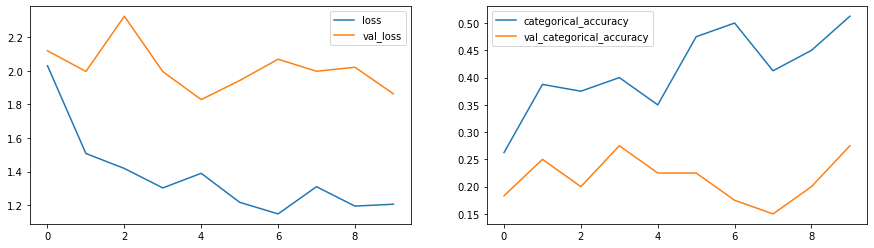

In [28]:
plot(model_history)

`Model 3 with image augumentation is performing better than model 1 and 2 on validation/testing set.`

## Model 4: Running on ablation dataset( training sample=100 and validation samples= 50 ) with Image cropping and resizing (120 x 120) and  image augumentation

In [30]:
img_height = 120
img_width = 120

In [31]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(num_imgs_per_video,img_height,img_width,num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_17 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 60, 60, 32)    

In [32]:
train_generator = generator(train_path, train_doc, batch_size,crop_resize=True,augmentation=True,ablation=ablation_train)
val_generator = generator(val_path, val_doc, batch_size,crop_resize=True,augmentation=True,ablation=ablation_val)

In [33]:
model_history= model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = ../input/gesturerecognition/Project_data/train ; batch size = 30
Epoch 1/10
4/4 [==============================] - 52s 17s/step - loss: 2.1172 - categorical_accuracy: 0.2417 - val_loss: 1.6032 - val_categorical_accuracy: 0.2167
Epoch 2/10
4/4 [==============================] - 68s 22s/step - loss: 1.9935 - categorical_accuracy: 0.3117 - val_loss: 1.6304 - val_categorical_accuracy: 0.1833
Epoch 3/10
4/4 [==============================] - 74s 25s/step - loss: 1.9737 - categorical_accuracy: 0.2083 - val_loss: 1.6110 - val_categorical_accuracy: 0.3250
Epoch 4/10
4/4 [==============================] - 74s 25s/step - loss: 1.7974 - categorical_accuracy: 0.3250 - val_loss: 1.6529 - val_categorical_accuracy: 0.2000
Epoch 5/10
4/4 [==============================] - 74s 25s/step - loss: 1.8011 - categorical_accuracy: 0.2800 - val_loss: 1.8238 - val_categorical_accuracy: 0.1500
Epoch 6/10
4/4 [==============================] - 81s 27s/step - loss: 1.8439 - categorical_accuracy: 0.26

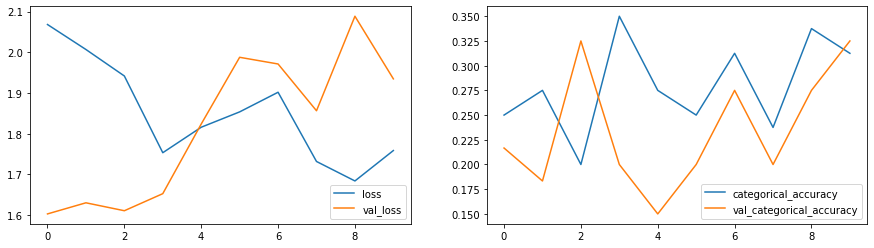

In [34]:
plot(model_history)

`Model 4 with image size (120 x120) is not performing better than model 3 with image size of 160 x160 on training and validation dataset/loss`

## Model 5: Running on Complete training and validation dataset with Image cropping and resizing  and image augumentation

In [40]:
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(num_imgs_per_video,img_height,img_width,num_channels)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(num_classes,activation='softmax'))

optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 160, 160, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 80, 80, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 80, 80, 32)     13856     
_________________________________________________________________
activation_9 (Activation)    (None, 8, 80, 80, 32)     0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 80, 80, 32)    

In [41]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
callbacks_list = [checkpoint, LR]

In [44]:
batch_size=30
train_generator = generator(train_path, train_doc, batch_size,crop_resize=True,augmentation=True,ablation=None)
val_generator = generator(val_path, val_doc, batch_size,crop_resize=True,augmentation=True,ablation=None)

In [45]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0,callbacks=callbacks_list)

Source path = Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - 2789s 123s/step - loss: 1.6276 - categorical_accuracy: 0.3089 - val_loss: 9.1016 - val_categorical_accuracy: 0.1688

Epoch 00001: saving model to model_init_2021-03-2722_12_45.887766\model-00001-1.62761-0.30894-9.10162-0.16875.h5
Epoch 2/10
23/23 [==============================] - 3282s 147s/step - loss: 1.7617 - categorical_accuracy: 0.2826 - val_loss: 10.8844 - val_categorical_accuracy: 0.2125

Epoch 00002: saving model to model_init_2021-03-2722_12_45.887766\model-00002-1.76166-0.28261-10.88439-0.21250.h5
Epoch 3/10
23/23 [==============================] - 6657s 300s/step - loss: 1.8595 - categorical_accuracy: 0.2101 - val_loss: 4.8566 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to model_init_2021-03-2722_12_45.887766\model-00003-1.85950-0.21014-4.85661-0.18750.h5
Epoch 4/10
23/23 [==============================] - 2521s 114s/step - loss: 1.8096 - categorical_accu

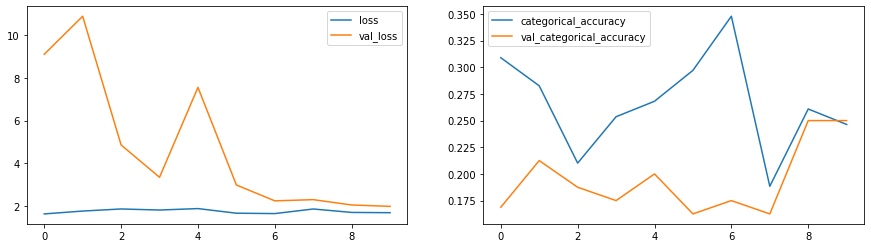

In [46]:
plot(model_history)

`Current Conv3d is not perrforming well on complete dataset`

# <font color='maroon'>CNN + LSTM/GRU</font>

# CNN + GRU

## Model 6: Running on Complete training and validation dataset with Image cropping and resizing  and image augumentation

In [17]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(num_imgs_per_video,img_height,img_width,num_channels)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
     
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))


model.add(GRU(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(num_classes, activation='softmax'))
optimiser = optimizers.Adam(lr=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 16, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 80, 80, 32)    4640      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 16, 40, 40, 64)   

In [24]:
train_generator = generator(train_path, train_doc, batch_size,crop_resize=True,augmentation=True,ablation=None)
val_generator = generator(val_path, val_doc, batch_size,crop_resize=True,augmentation=True,ablation=None)

In [25]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=15, verbose=1, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path = Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - 2484s 112s/step - loss: 1.9401 - categorical_accuracy: 0.1748 - val_loss: 2.1052 - val_categorical_accuracy: 0.1937
Epoch 2/15
23/23 [==============================] - 2495s 112s/step - loss: 1.7396 - categorical_accuracy: 0.2464 - val_loss: 1.9675 - val_categorical_accuracy: 0.2125
Epoch 3/15
23/23 [==============================] - 2481s 112s/step - loss: 1.8097 - categorical_accuracy: 0.1957 - val_loss: 1.7664 - val_categorical_accuracy: 0.2000
Epoch 4/15
23/23 [==============================] - 2484s 112s/step - loss: 1.7727 - categorical_accuracy: 0.2319 - val_loss: 1.6362 - val_categorical_accuracy: 0.2000
Epoch 5/15
23/23 [==============================] - 2511s 113s/step - loss: 1.7439 - categorical_accuracy: 0.1812 - val_loss: 1.6349 - val_categorical_accuracy: 0.1500
Epoch 6/15
23/23 [==============================] - 2491s 112s/step - loss: 1.6388 - categorical_accuracy: 0.

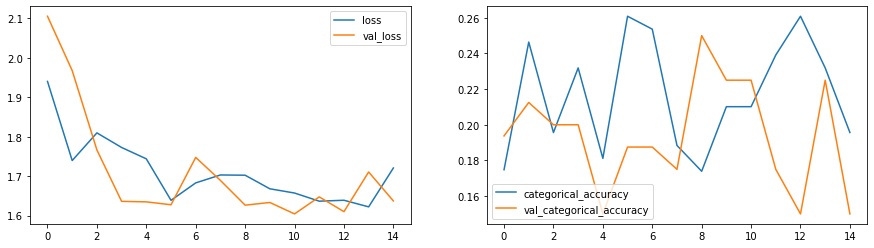

In [26]:
plot(model_history)

` Model 5 is not performing. Validation and Training accuracy is very low.`

# Transfer learning with trainbale layers( MobileNet + GRU)

## Model 7: Running on Complete training and validation dataset with Image cropping and resizing  and image augumentation

In [27]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
        
model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_imgs_per_video,img_height,img_width,num_channels)))
 
        
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(num_classes, activation='softmax'))
        
        
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

17227776/17225924 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, 16, 5, 5, 1024)    3228864   
_________________________________________________________________
time_distributed_16 (TimeDis (None, 16, 5, 5, 1024)    4096      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 2, 2, 1024)    0         
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 4096)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                799104    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_______________________________________________________

In [28]:
train_generator = generator(train_path, train_doc, batch_size,crop_resize=True,augmentation=True,ablation=None)
val_generator = generator(val_path, val_doc, batch_size,crop_resize=True,augmentation=True,ablation=None)

In [31]:
model_history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0,callbacks=callbacks_list)

Source path = Project_data/train ; batch size = 30
Epoch 1/25
23/23 [==============================] - 2800s 120s/step - loss: 1.6777 - categorical_accuracy: 0.2969 - val_loss: 1.6781 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2021-03-2722_12_45.887766\model-00001-1.72095-0.26423-1.67811-0.30000.h5
Epoch 2/25
23/23 [==============================] - 2631s 118s/step - loss: 1.7590 - categorical_accuracy: 0.2973 - val_loss: 1.6649 - val_categorical_accuracy: 0.2875

Epoch 00002: saving model to model_init_2021-03-2722_12_45.887766\model-00002-1.72698-0.31159-1.66486-0.28750.h5
Epoch 3/25
23/23 [==============================] - 2592s 117s/step - loss: 1.6631 - categorical_accuracy: 0.2217 - val_loss: 1.5626 - val_categorical_accuracy: 0.3375

Epoch 00003: saving model to model_init_2021-03-2722_12_45.887766\model-00003-1.67104-0.23188-1.56260-0.33750.h5
Epoch 4/25
23/23 [==============================] - 2618s 118s/step - loss: 1.6749 - categorical_accura

` We ran it for less number of epochs because of execution time but accuracy keeps increasing after 25th epoch`

`Model 7 is our final model`

# Thank YOu :)